In [1]:
import kagglehub

path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import os
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import cv2
import numpy as np
import pandas as pd
from torchvision.models import ResNet18_Weights
import random

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
class ChannelAttention(nn.Module):

  def __init__(self, channels, reduction = 16, dropout = 0.1):
    super().__init__()

    # Global Average Pooling:
    # Compresses each channel into a single number (its average across H and W).
    # Output shape: (batch, channels, 1, 1)
    self.avg_pool = nn.AdaptiveAvgPool2d(1)

    # Fully connected layers for attention mechanism
    self.fc = nn.Sequential(
        # First Linear layer: reduce dimensionality
        # Input: channels → Output: channels // reduction
        nn.Linear(channels, channels // reduction, bias = False),

        # Dropout for regularization
        nn.Dropout(dropout),

        # GLU: Gated Linear Unit
        # Splits the input into 2 halves:
        # first half = values, second half = gates
        #  output = values * sigmoid(gates)
        # So output size = (channels // reduction) // 2
        nn.GLU(),

        # Second Linear: expand back to original channel size
        # Input: (channels // reduction // 2) → Output: channels
        nn.Linear(channels // reduction // 2, channels, bias = False),

        # Sigmoid: scale attention weights to [0, 1]
        nn.Sigmoid()
    )

  def forward(self, x):
      # Extract dimensions from input tensor
      # x has shape (batch, channels, height, width)
      b, c, _, _ = x.size()

      # Global Average Pooling
      # Shape: (b, c, 1, 1) → reshape to (b, c)
      y = self.avg_pool(x).view(b, c)

      # Generate per-channel attention weights
      # Shape after fc: (b, c) → reshape to (b, c, 1, 1)
      attention_weights = self.fc(y).view(b, c, 1, 1)

      # Scale input features by attention weights (broadcast across H and W)
      # Returns: weighted feature maps: (b, c, h, w) & attention weights themselves (for analysis/visualization)
      return x * attention_weights.expand_as(x), attention_weights

In [5]:
class ResNetWithAttention(nn.Module):

  def __init__(self, num_classes = 2):
      super().__init__()

      # Load pretrained ResNet18
      self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

      # Replace final fully connected layer for custom classification
      self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

      # Insert a ChannelAttention gate after every residual block
      self.gates = nn.ModuleList()
      for layer in [self.resnet.layer1, self.resnet.layer2, self.resnet.layer3, self.resnet.layer4]:
          for block in layer:
              self.gates.append(ChannelAttention(block.conv2.out_channels))

  def forward(self, x):
      # Initial ResNet architecture
      x = self.resnet.conv1(x)
      x = self.resnet.bn1(x)
      x = self.resnet.relu(x)
      x = self.resnet.maxpool(x)

      gate_idx = 0
      self.attention_weights = []

      # Go through all residual blocks with attention inserted
      for layer in [self.resnet.layer1, self.resnet.layer2, self.resnet.layer3, self.resnet.layer4]:
          for block in layer:

              identity = x

              # Main block path
              x = block.conv1(x)
              x = block.bn1(x)
              x = block.relu(x)
              x = block.conv2(x)
              x = block.bn2(x)

              # Apply channel attention before adding residual
              x, attention_weights = self.gates[gate_idx](x)
              self.attention_weights.append(attention_weights)
              gate_idx += 1

              # Match dimensions if needed
              if block.downsample is not None:
                  identity = block.downsample(identity)

              # Add residual and activate
              x += identity
              x = block.relu(x)

      # Global pooling + classifier head
      x = self.resnet.avgpool(x)
      x = torch.flatten(x, 1)
      y = self.resnet.fc(x)

      return y

In [6]:
class PlainResNet18(nn.Module):

    def __init__(self, num_classes=2):
        super().__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Replacing the classification layers for finetuning
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):

    # Set model to training mode
    model.train()

    total_loss = 0
    preds, targets = [], []
    batch_losses = []

    # Progress bar for training loop
    loop = tqdm(dataloader, desc='Training', leave=True)

    for images, labels in loop:
        # Move inputs and targets to GPU (or CPU if no GPU)
        images, labels = images.to(device), labels.to(device)

        # Reset gradients from previous step
        optimizer.zero_grad()

        # Forward pass: compute predictions
        outputs = model(images)

        # Compute loss against true labels
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update model weights
        optimizer.step()

        # Convert loss tensor to float
        loss = loss.item()

        # Save per-batch loss for later analysis/plotting
        batch_losses.append(loss)

        # Accumulate total loss weighted by batch size
        total_loss += loss * images.size(0)

        # Save predictions and true labels for accuracy/F1
        preds.extend(torch.argmax(outputs, dim=1).cpu().tolist())
        targets.extend(labels.cpu().tolist())

    # Compute average loss for the whole epoch
    avg_loss = total_loss / len(dataloader.dataset)

    # Calculate accuracy and F1 score over the epoch
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)

    return avg_loss, acc, f1, batch_losses


def eval_epoch(model, dataloader, criterion, device, description="Evaluating"):
    # Set model to evaluation mode (disables dropout & batchnorm updates)
    model.eval()

    total_loss = 0
    preds, targets = [], []
    probabilities = []

    # Progress bar for evaluation loop
    loop = tqdm(dataloader, desc=description, leave=True)

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for images, labels in loop:
            # Move inputs and targets to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass only
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            # Compute class probabilities with softmax
            probs = F.softmax(outputs, dim=1)
            probabilities.extend(probs.cpu().numpy())

            # Get predicted classes
            preds.extend(torch.argmax(outputs, dim=1).cpu().tolist())
            targets.extend(labels.cpu().tolist())

            # Show current batch loss on progress bar
            loop.set_postfix(loss=loss.item())

    # Compute average loss across dataset
    avg_loss = total_loss / len(dataloader.dataset)

    # Calculate accuracy and F1 score over dataset
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)

    return avg_loss, acc, f1, preds, targets, probabilities

In [8]:
def freeze_layers(num_layers):

    # Create two models: one with attention and one plain ResNet18
    attention_model = ResNetWithAttention(num_classes=2)
    plain_model = PlainResNet18(num_classes=2)

    # Freeze all ResNet layers except the final fully connected layer
    for model in [attention_model, plain_model]:
        for param in model.resnet.parameters():
            param.requires_grad = False
        for param in model.resnet.fc.parameters():
            param.requires_grad = True

    # Allow training of attention gates in the attention model
    for param in attention_model.gates.parameters():
        param.requires_grad = True

    # Unfreeze the last `num_layers` residual layers for fine-tuning strategies
    for layer in ["layer4", "layer3", "layer2", "layer1"][:num_layers]:
        for model in [attention_model, plain_model]:
            for param in getattr(model.resnet, layer).parameters():
                param.requires_grad = True

    return attention_model, plain_model

In [9]:
def plot_training_curves(results_dict, unfreeze_layers):

    """Plot training and validation curves for both models"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Training Progress - {unfreeze_layers} Unfrozen Layers', fontsize=16, fontweight='bold')

    metrics = ['loss', 'accuracy', 'f1']

    for i, metric in enumerate(metrics):

        # Training curves
        ax_train = axes[0, i]
        for model_name in results_dict:
            epochs = range(1, len(results_dict[model_name][f'train_{metric}']) + 1)
            ax_train.plot(epochs, results_dict[model_name][f'train_{metric}'],
                         marker='o', label=f'{model_name}', linewidth=2)
        ax_train.set_title(f'Training {metric.capitalize()}', fontweight='bold')
        ax_train.set_xlabel('Epoch')
        ax_train.set_ylabel(metric.capitalize())
        ax_train.legend()
        ax_train.grid(True, alpha=0.3)

        # Validation curves
        ax_val = axes[1, i]
        for model_name in results_dict:
            epochs = range(1, len(results_dict[model_name][f'val_{metric}']) + 1)
            ax_val.plot(epochs, results_dict[model_name][f'val_{metric}'],
                       marker='s', label=f'{model_name}', linewidth=2)
        ax_val.set_title(f'Validation {metric.capitalize()}', fontweight='bold')
        ax_val.set_xlabel('Epoch')
        ax_val.set_ylabel(metric.capitalize())
        ax_val.legend()
        ax_val.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_names=['Uninfected', 'Parasitized']):

    """Plot confusion matrix"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [11]:
def visualize_attention_weights(model, sample_images, device, save_path=None):

    """Visualize attention weights for sample images"""
    model.eval()

    with torch.no_grad():
        sample_images = sample_images.to(device)
        _ = model(sample_images)

        if hasattr(model, 'attention_weights') and model.attention_weights:
            # Take the last attention layer weights
            att_weights = model.attention_weights[-1]  # Shape: [batch, channels, 1, 1]
            att_weights = att_weights.squeeze().cpu().numpy()

            if len(att_weights.shape) == 1:
                att_weights = att_weights.reshape(1, -1)

            fig, axes = plt.subplots(2, min(4, sample_images.shape[0]), figsize=(16, 8))
            if sample_images.shape[0] == 1:
                axes = axes.reshape(2, 1)

            for i in range(min(4, sample_images.shape[0])):

                # Original image
                img = sample_images[i].cpu().numpy().transpose(1, 2, 0)
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
                img = np.clip(img, 0, 1)

                axes[0, i].imshow(img)
                axes[0, i].set_title(f'Original Image {i+1}')
                axes[0, i].axis('off')

                # Attention weights
                weights = att_weights[i] if len(att_weights.shape) > 1 else att_weights
                axes[1, i].bar(range(len(weights)), weights, alpha=0.7)
                axes[1, i].set_title(f'Channel Attention Weights {i+1}')
                axes[1, i].set_xlabel('Channel')
                axes[1, i].set_ylabel('Attention Weight')
                axes[1, i].grid(True, alpha=0.3)

            plt.suptitle('Channel Attention Visualization', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

In [12]:
def analyse(train_loader, val_loader, test_loader, unfreeze_layers=0, epochs=5):

    # CrossEntropy loss
    criterion = nn.CrossEntropyLoss()

    # Use GPU if available, otherwise fall back to CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    results = {}

    # Initialize both models (attention vs plain), freezing/unfreezing as specified
    attention_model, plain_model = freeze_layers(unfreeze_layers)

    # Move models to selected device
    attention_model.to(device)
    plain_model.to(device)

    tqdm.write(f"Number of unfrozen layers: {unfreeze_layers}")

    # Train both models separately and compare
    for model_name, model in [('ResNet18 with Attention', attention_model),
                              ('Plain ResNet18', plain_model)]:

        tqdm.write(f"Training {model_name} model...")

        # Track training & validation metrics across epochs
        train_losses, train_accs, train_f1s = [], [], []
        val_losses, val_accs, val_f1s = [], [], []
        batch_losses = []

        # Run training for the specified number of epochs
        for epoch in range(epochs):

            # Optimizer only updates trainable parameters
            optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

            # Train one full epoch
            train_loss, train_acc, train_f1, batch_loss = train_epoch(
                model, train_loader, criterion, optimizer, device
            )

            # Validate model on the validation set
            val_loss, val_acc, val_f1, _, _, _ = eval_epoch(
                model, val_loader, criterion, device
            )

            # Print summary for this epoch
            tqdm.write(
                f"Epoch {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
                f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}"
            )

            # Save results for later visualization and analysis
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            train_f1s.append(train_f1)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)
            batch_losses.extend(batch_loss)

        # After training, evaluate on the test set for final performance
        test_loss, test_acc, test_f1, test_preds, test_targets, test_probs = eval_epoch(
            model, test_loader, criterion, device, description="Testing"
        )

        tqdm.write(
            f"Final Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}"
        )

        # Store results in dictionary for reporting and plotting
        results[model_name] = {
            'train_loss': train_losses,
            'train_accuracy': train_accs,
            'train_f1': train_f1s,
            'val_loss': val_losses,
            'val_accuracy': val_accs,
            'val_f1': val_f1s,
            'test_loss': test_loss,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'test_predictions': test_preds,
            'test_targets': test_targets,
            'test_probabilities': test_probs
        }

        # Show confusion matrix for test set
        plot_confusion_matrix(test_targets, test_preds, model_name)

    # After both models are trained: plot training/validation curves
    plot_training_curves(results, unfreeze_layers)

    # Visualize attention maps for the attention model
    if 'ResNet18 with Attention' in results:
        sample_batch = next(iter(test_loader))
        sample_images = sample_batch[0][:4]
        visualize_attention_weights(attention_model, sample_images, device)

    return results

In [13]:
path = path + "/cell_images/cell_images"

# Load dataset with labels inferred from folder structure
dataset = datasets.ImageFolder(path)

# Split dataset sizes: 70% train, 15% val, 15% test
size = len(dataset)
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = size - train_size - val_size

# Generate random indices for train, validation, and test splits
train_idx, val_idx, test_idx = random_split(range(size),
                                            [train_size, val_size, test_size])

# Data augmentation and normalization for training
# Resize to 224x224 for ResNet input
# Random flips and rotations improve generalization
# Convert to tensor and normalize using ImageNet statistics
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Only resizing and normalization for validation and testing
# No augmentation to keep evaluation consistent
test_val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create subsets for train, validation, and test using the defined transforms
train_dataset = Subset(datasets.ImageFolder(path, transform=train_transforms), train_idx)
val_dataset = Subset(datasets.ImageFolder(path, transform=test_val_transforms), val_idx)
test_dataset = Subset(datasets.ImageFolder(path, transform=test_val_transforms), test_idx)

# Training loader shuffles data for better learning
# Validation and test loaders do not shuffle to ensure repeatability
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [14]:
def plot_sample_images(dataset, class_names=['Parasitized', 'Uninfected']):

    """Plot sample images from the dataset"""

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    samples_per_class = 4
    class_samples = {0: [], 1: []}

    # Collect samples from each class
    for i, (image, label) in enumerate(dataset):
        if len(class_samples[label]) < samples_per_class:
            class_samples[label].append((image, label))
        if all(len(samples) >= samples_per_class for samples in class_samples.values()):
            break

    for class_idx, class_name in enumerate(class_names):
        for sample_idx in range(samples_per_class):
            if sample_idx < len(class_samples[class_idx]):
                image, label = class_samples[class_idx][sample_idx]

                # Denormalize the image
                img = image.numpy().transpose(1, 2, 0)
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
                img = np.clip(img, 0, 1)

                axes[class_idx, sample_idx].imshow(img)
                axes[class_idx, sample_idx].set_title(f'{class_name}')
                axes[class_idx, sample_idx].axis('off')

    plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

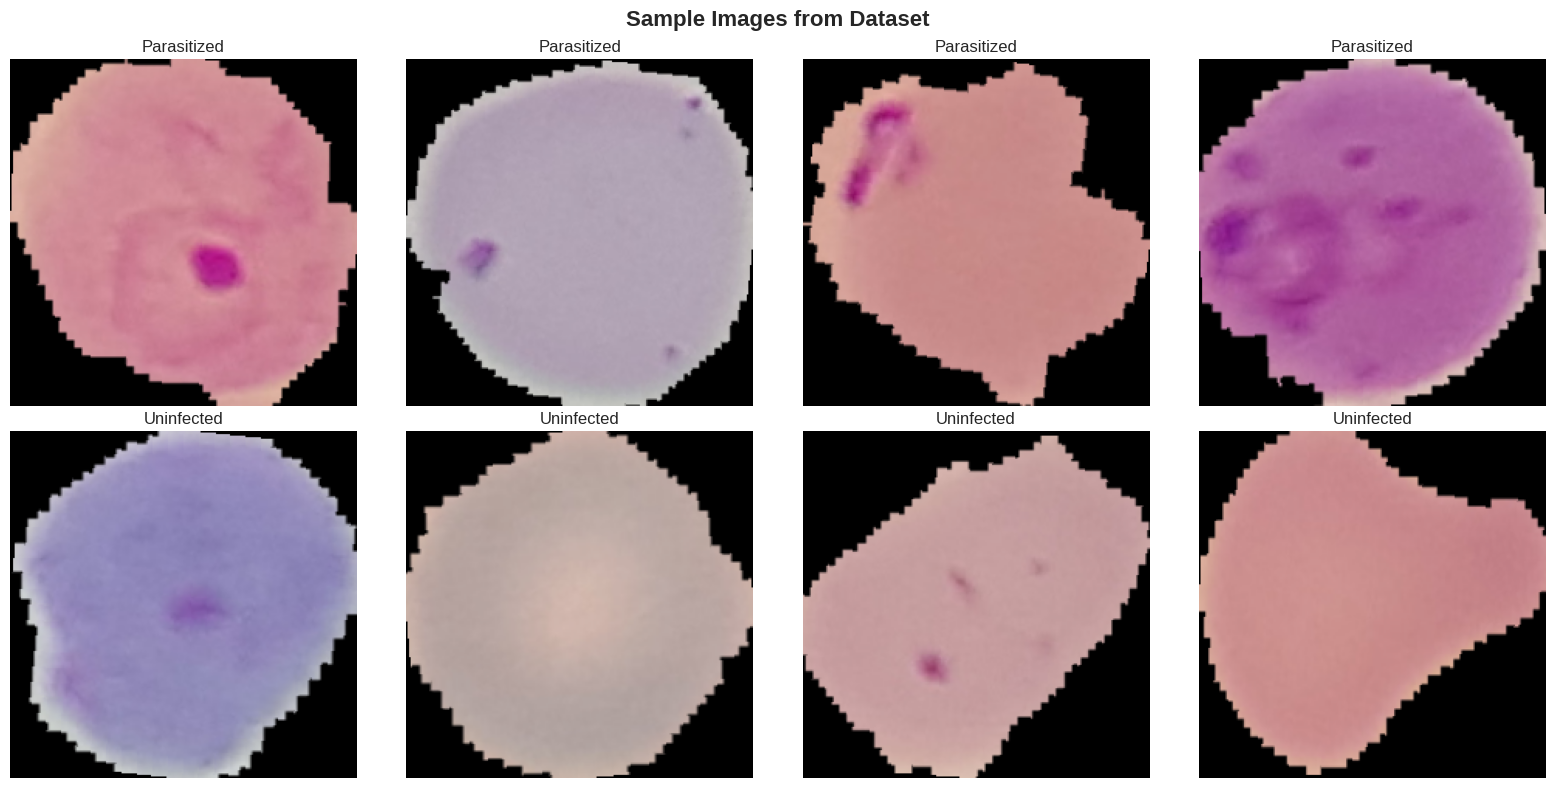

In [43]:
plot_sample_images(train_dataset)

In [19]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [20]:
attention_model, plain_model = freeze_layers(0)

total_att, trainable_att = count_parameters(attention_model)
total_plain, trainable_plain = count_parameters(plain_model)

print(f"ResNet18 with Attention: Total params = {total_att:,}, Trainable = {trainable_att:,}")
print(f"Plain ResNet18:          Total params = {total_plain:,}, Trainable = {trainable_plain:,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18 with Attention: Total params = 11,242,818, Trainable = 66,306
Plain ResNet18:          Total params = 11,177,538, Trainable = 1,026


In [ ]:
print(attention_model)

In [ ]:
print(plain_model)

In [15]:
all_results = {}

Number of unfrozen layers: 0
Training ResNet18 with Attention model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.4262, Acc: 0.8364, F1: 0.8394 | Val Loss: 0.2745, Acc: 0.8998, F1: 0.9025


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.2196, Acc: 0.9194, F1: 0.9200 | Val Loss: 0.2104, Acc: 0.9257, F1: 0.9259


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.1859, Acc: 0.9324, F1: 0.9330 | Val Loss: 0.1875, Acc: 0.9349, F1: 0.9353


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.1672, Acc: 0.9383, F1: 0.9392


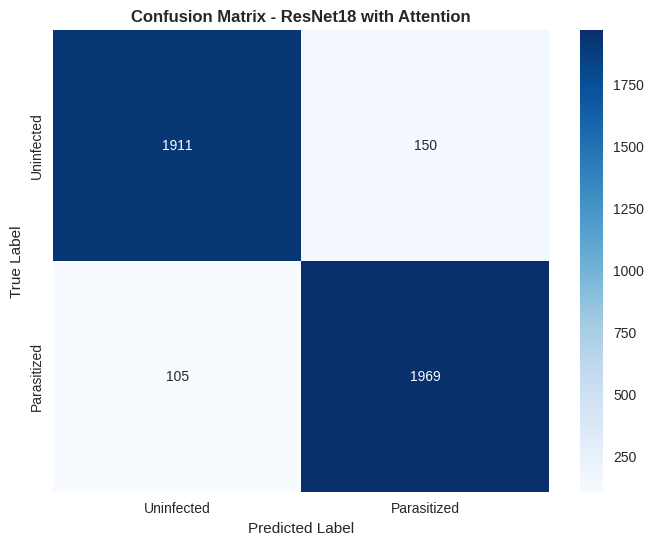

Training Plain ResNet18 model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.5357, Acc: 0.7476, F1: 0.7514 | Val Loss: 0.4467, Acc: 0.8188, F1: 0.8262


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.3755, Acc: 0.8595, F1: 0.8615 | Val Loss: 0.3723, Acc: 0.8471, F1: 0.8512


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.3313, Acc: 0.8730, F1: 0.8744 | Val Loss: 0.3449, Acc: 0.8572, F1: 0.8599


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.3188, Acc: 0.8837, F1: 0.8864


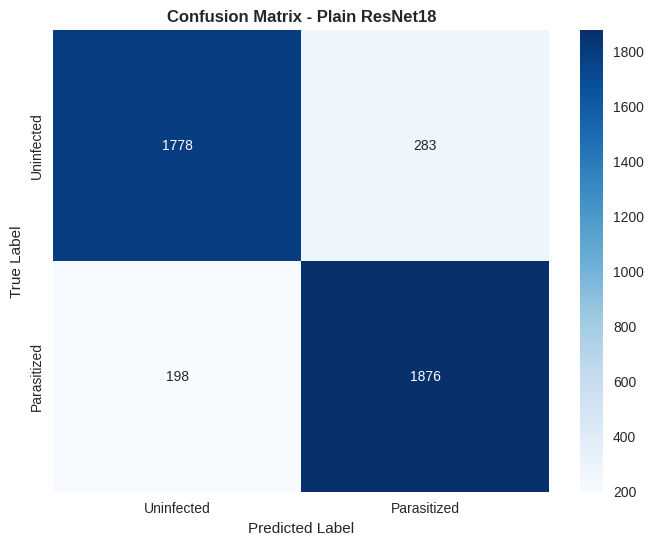

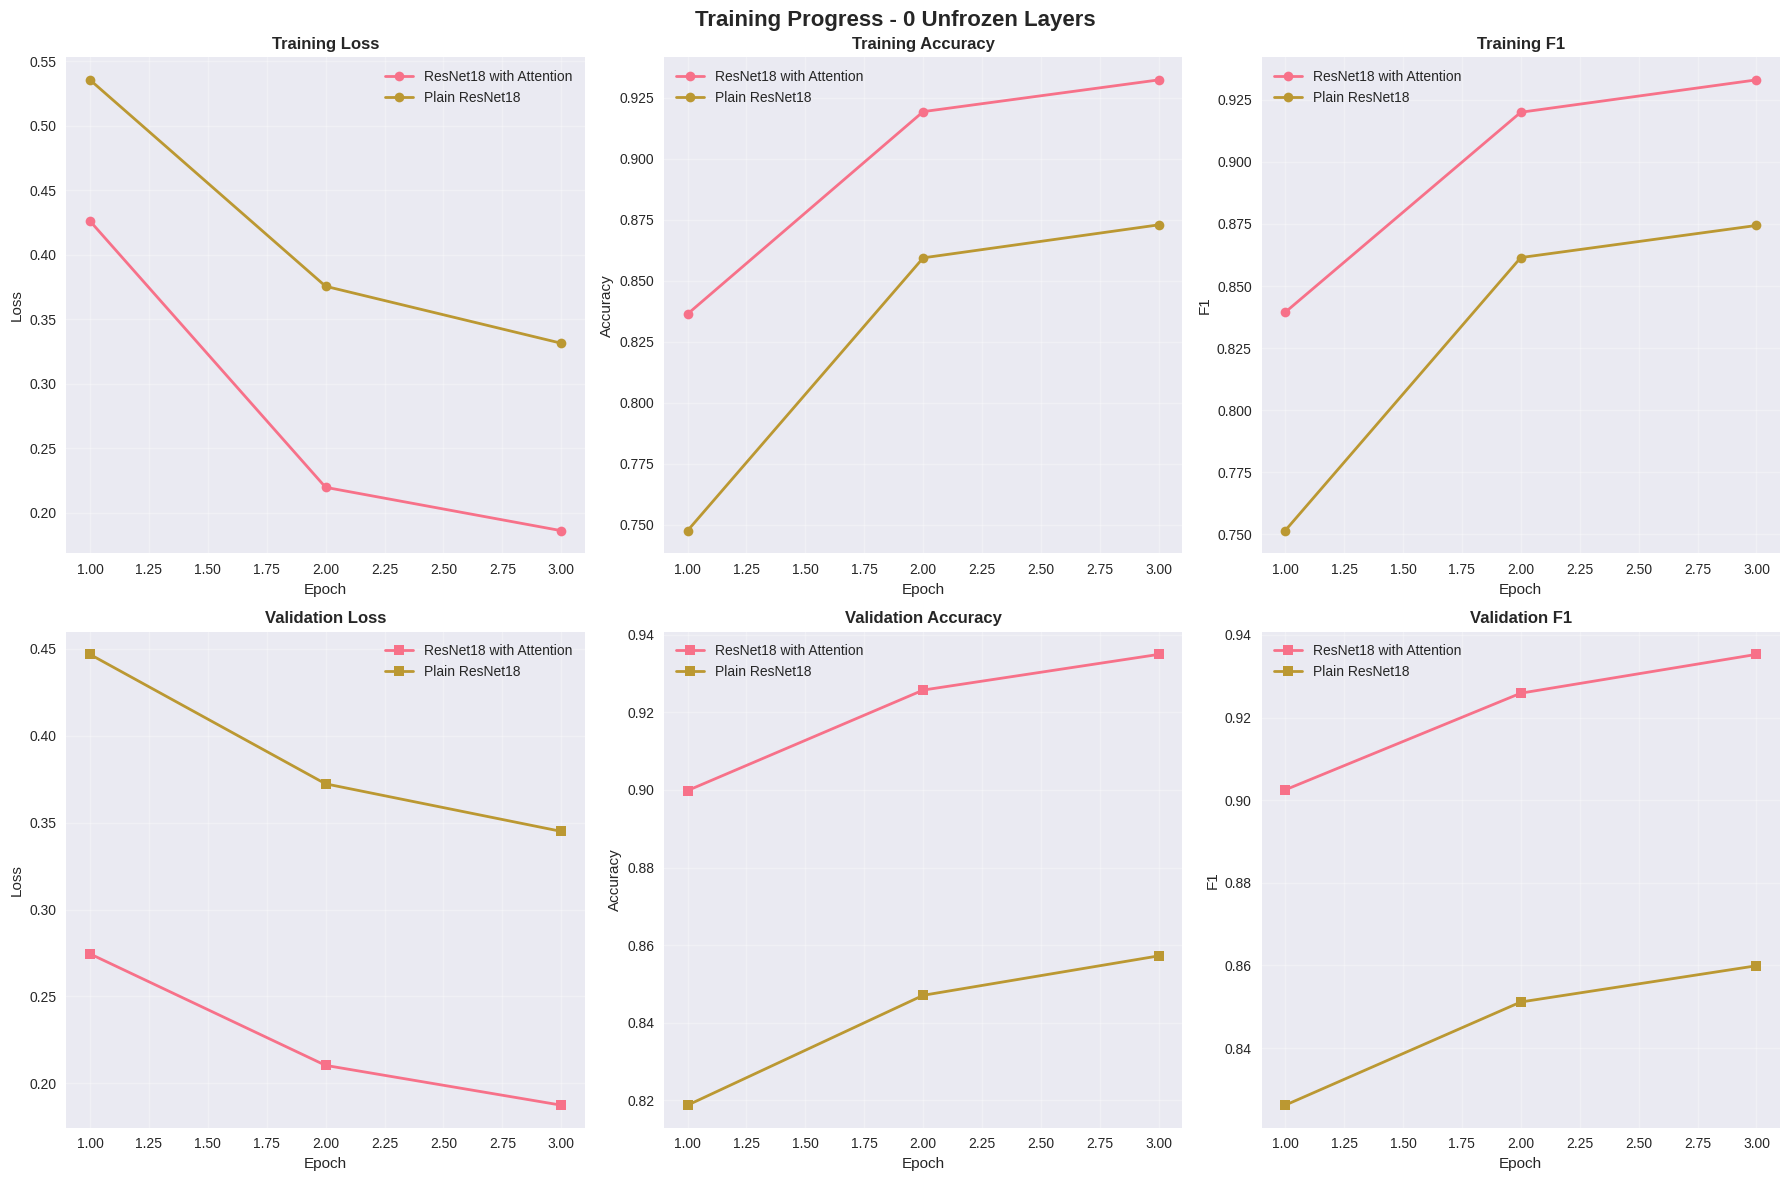

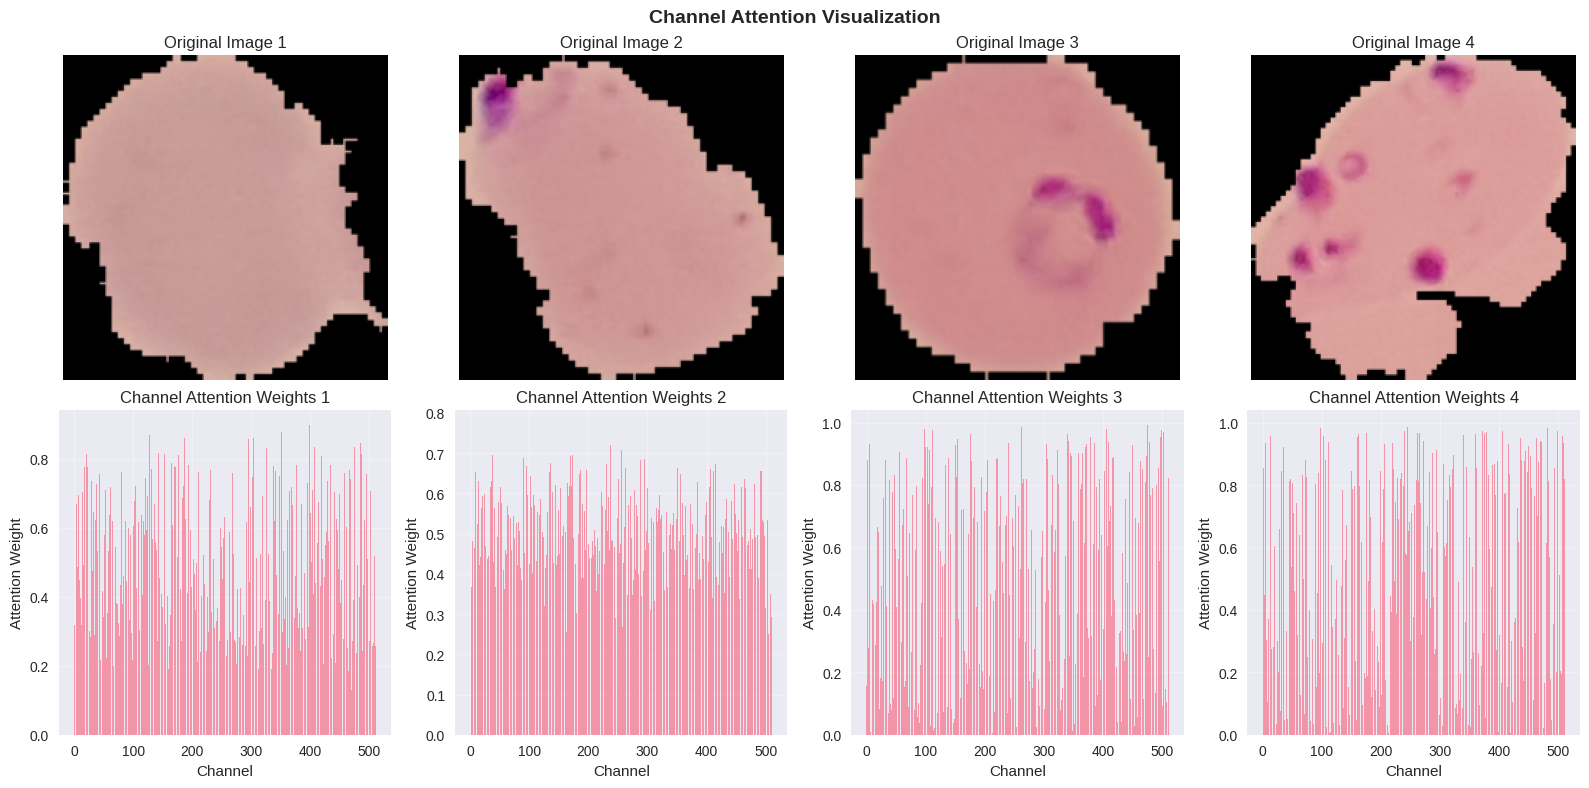

In [45]:
results = analyse(train_loader, val_loader, test_loader, unfreeze_layers=0, epochs=3)
all_results['0'] = results

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of unfrozen layers: 1
Training ResNet18 with Attention model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1443, Acc: 0.9485, F1: 0.9489 | Val Loss: 0.1093, Acc: 0.9574, F1: 0.9575


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0975, Acc: 0.9652, F1: 0.9655 | Val Loss: 0.1106, Acc: 0.9591, F1: 0.9597


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0838, Acc: 0.9691, F1: 0.9693 | Val Loss: 0.1009, Acc: 0.9615, F1: 0.9617


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.0946, Acc: 0.9671, F1: 0.9675


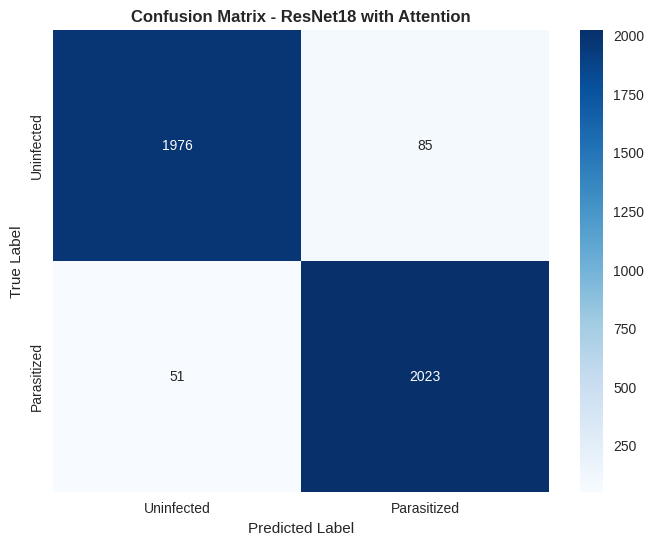

Training Plain ResNet18 model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1492, Acc: 0.9445, F1: 0.9451 | Val Loss: 0.1216, Acc: 0.9560, F1: 0.9563


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.1039, Acc: 0.9626, F1: 0.9630 | Val Loss: 0.1097, Acc: 0.9603, F1: 0.9604


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0876, Acc: 0.9686, F1: 0.9689 | Val Loss: 0.1107, Acc: 0.9598, F1: 0.9600


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.1032, Acc: 0.9652, F1: 0.9657


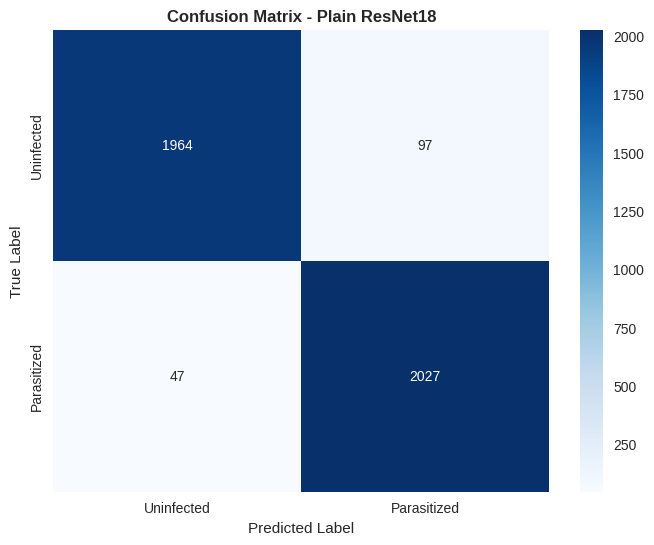

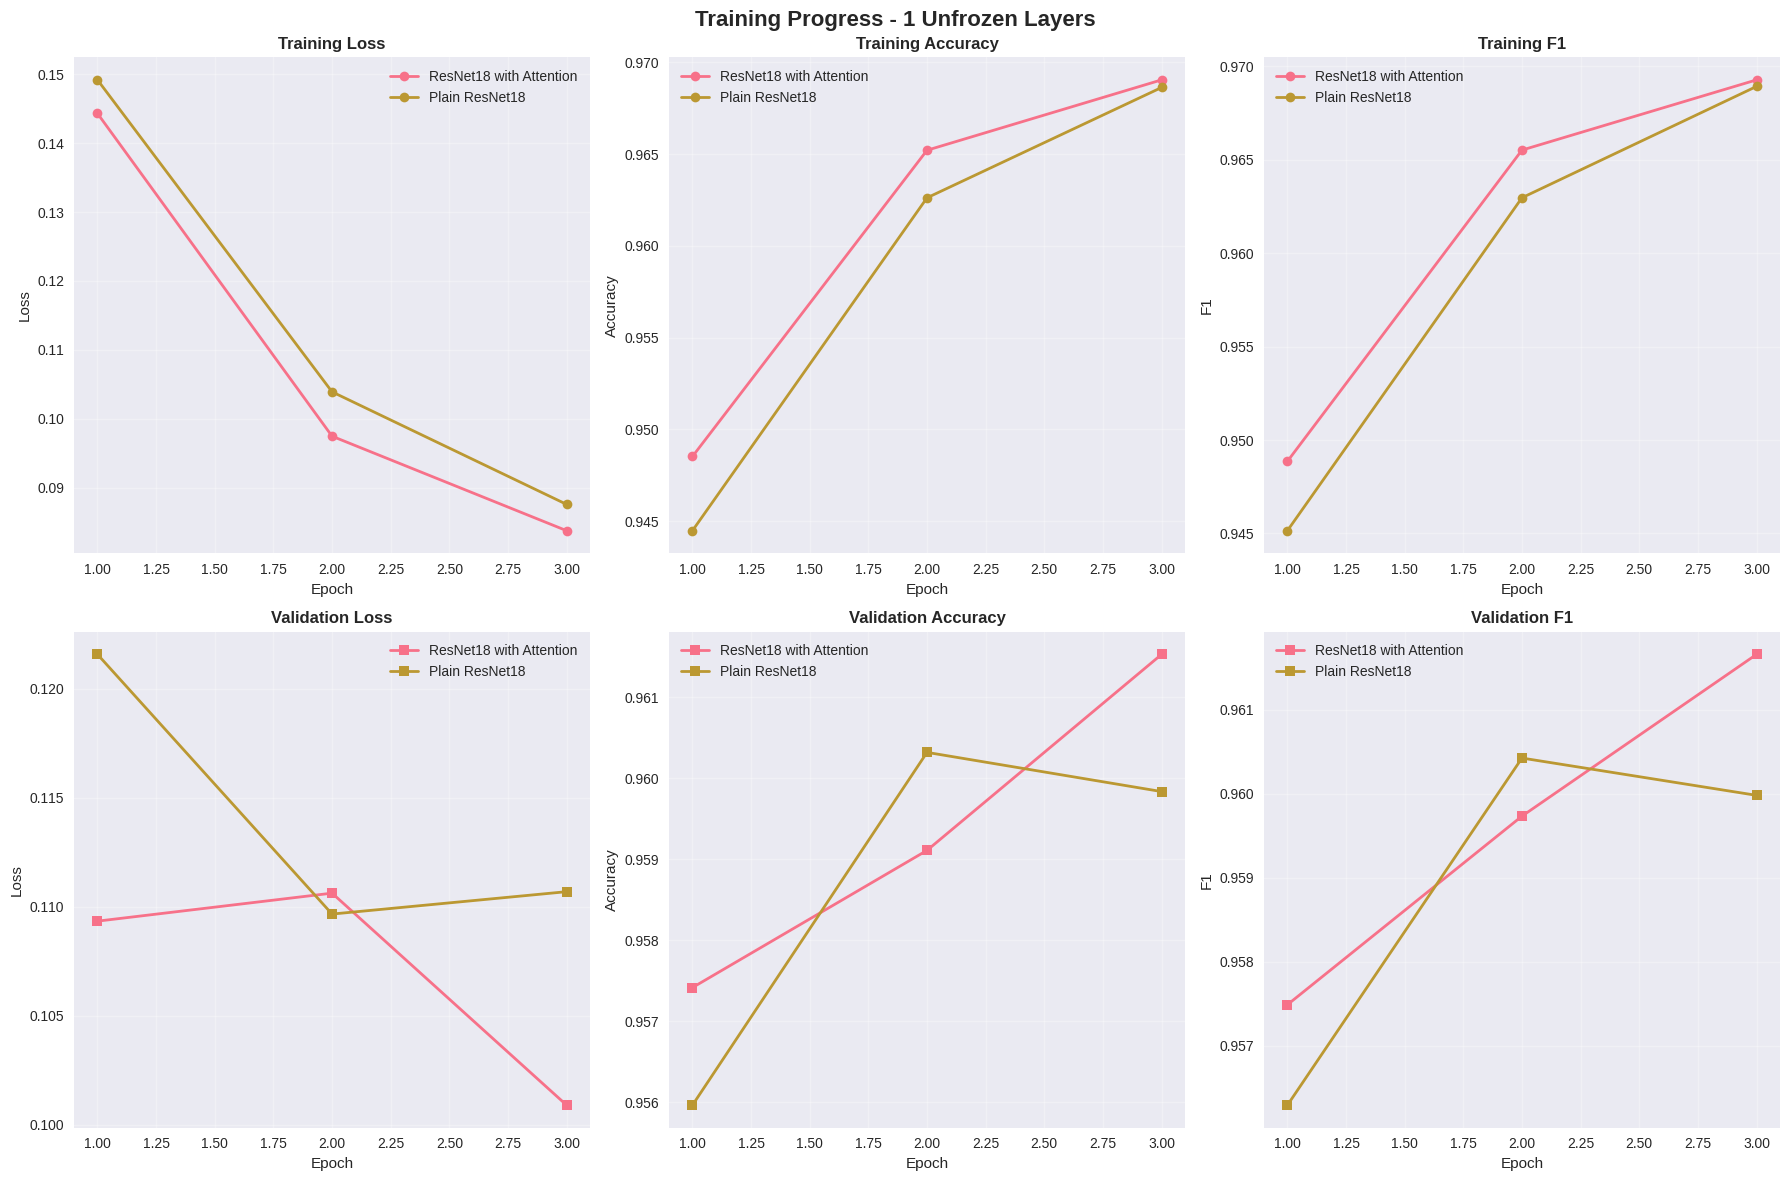

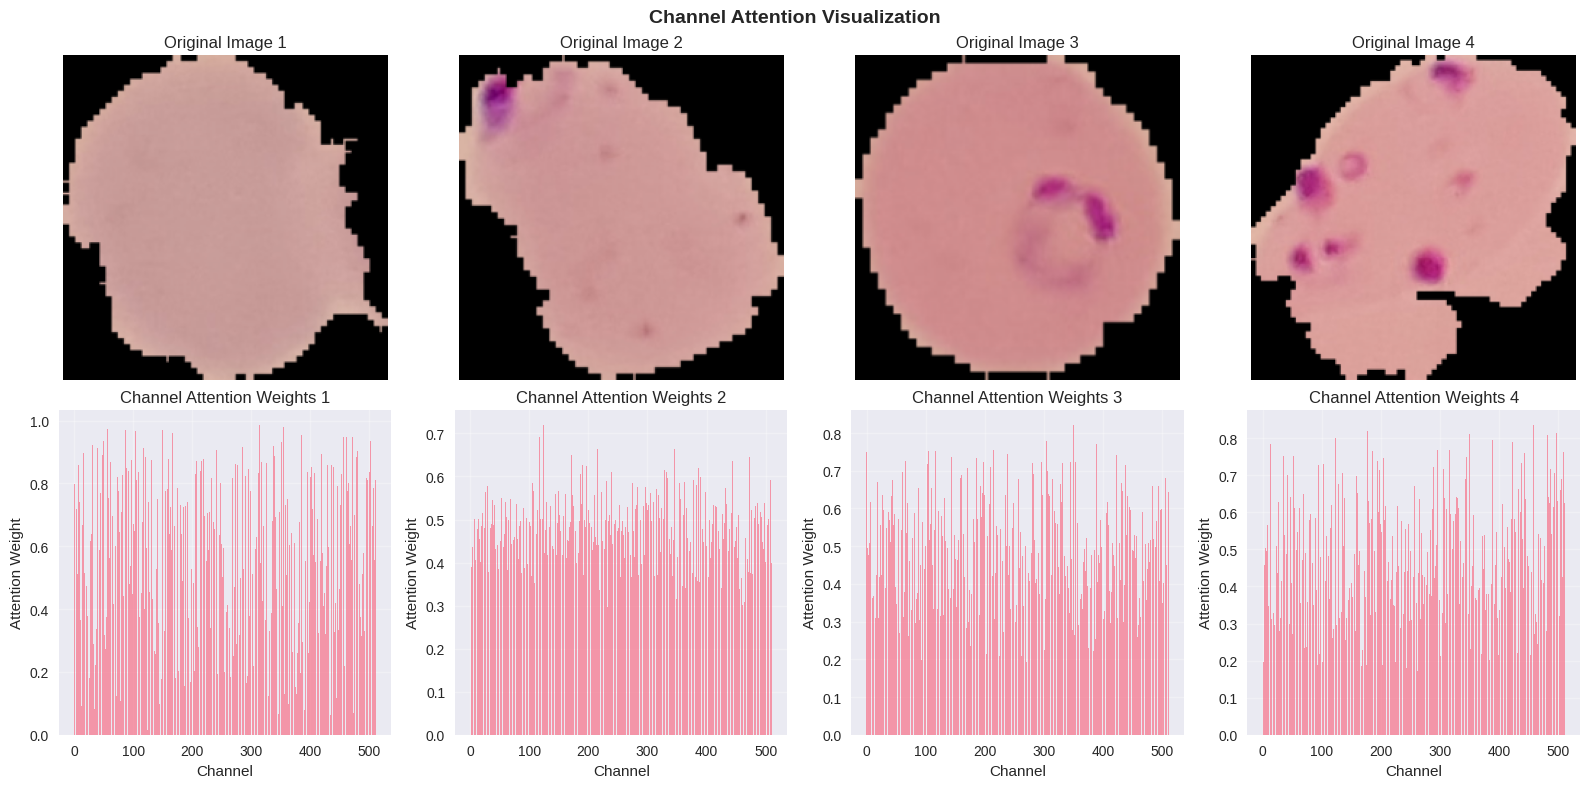

In [46]:
results = analyse(train_loader, val_loader, test_loader, unfreeze_layers=1, epochs=3)
all_results['1'] = results

Number of unfrozen layers: 2
Training ResNet18 with Attention model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1347, Acc: 0.9502, F1: 0.9511 | Val Loss: 0.0994, Acc: 0.9635, F1: 0.9643


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0930, Acc: 0.9681, F1: 0.9684 | Val Loss: 0.0914, Acc: 0.9678, F1: 0.9684


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0783, Acc: 0.9721, F1: 0.9723 | Val Loss: 0.0905, Acc: 0.9676, F1: 0.9679


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.0953, Acc: 0.9666, F1: 0.9665


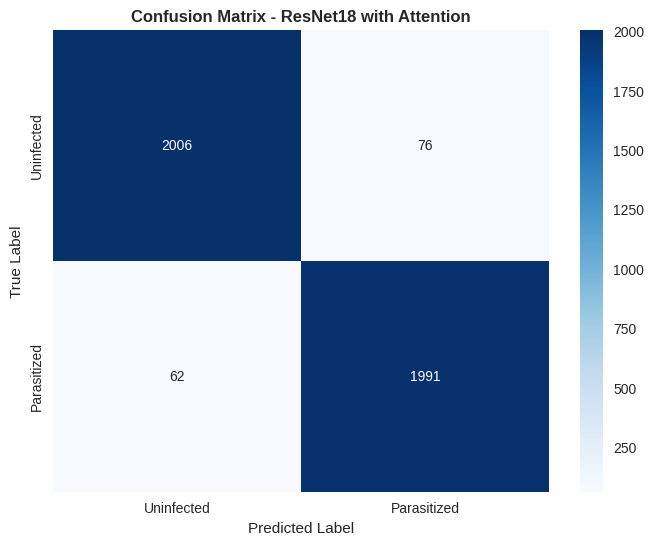

Training Plain ResNet18 model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1347, Acc: 0.9499, F1: 0.9506 | Val Loss: 0.1016, Acc: 0.9615, F1: 0.9624


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0941, Acc: 0.9681, F1: 0.9684 | Val Loss: 0.0899, Acc: 0.9666, F1: 0.9672


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0830, Acc: 0.9711, F1: 0.9714 | Val Loss: 0.0829, Acc: 0.9681, F1: 0.9687


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.0962, Acc: 0.9652, F1: 0.9655


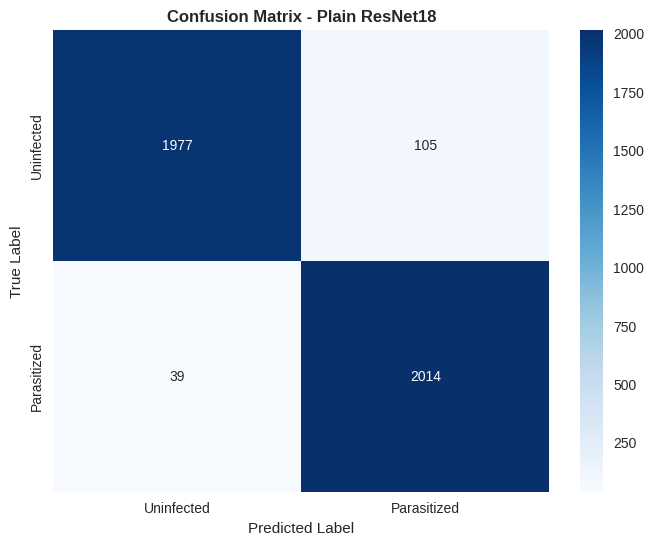

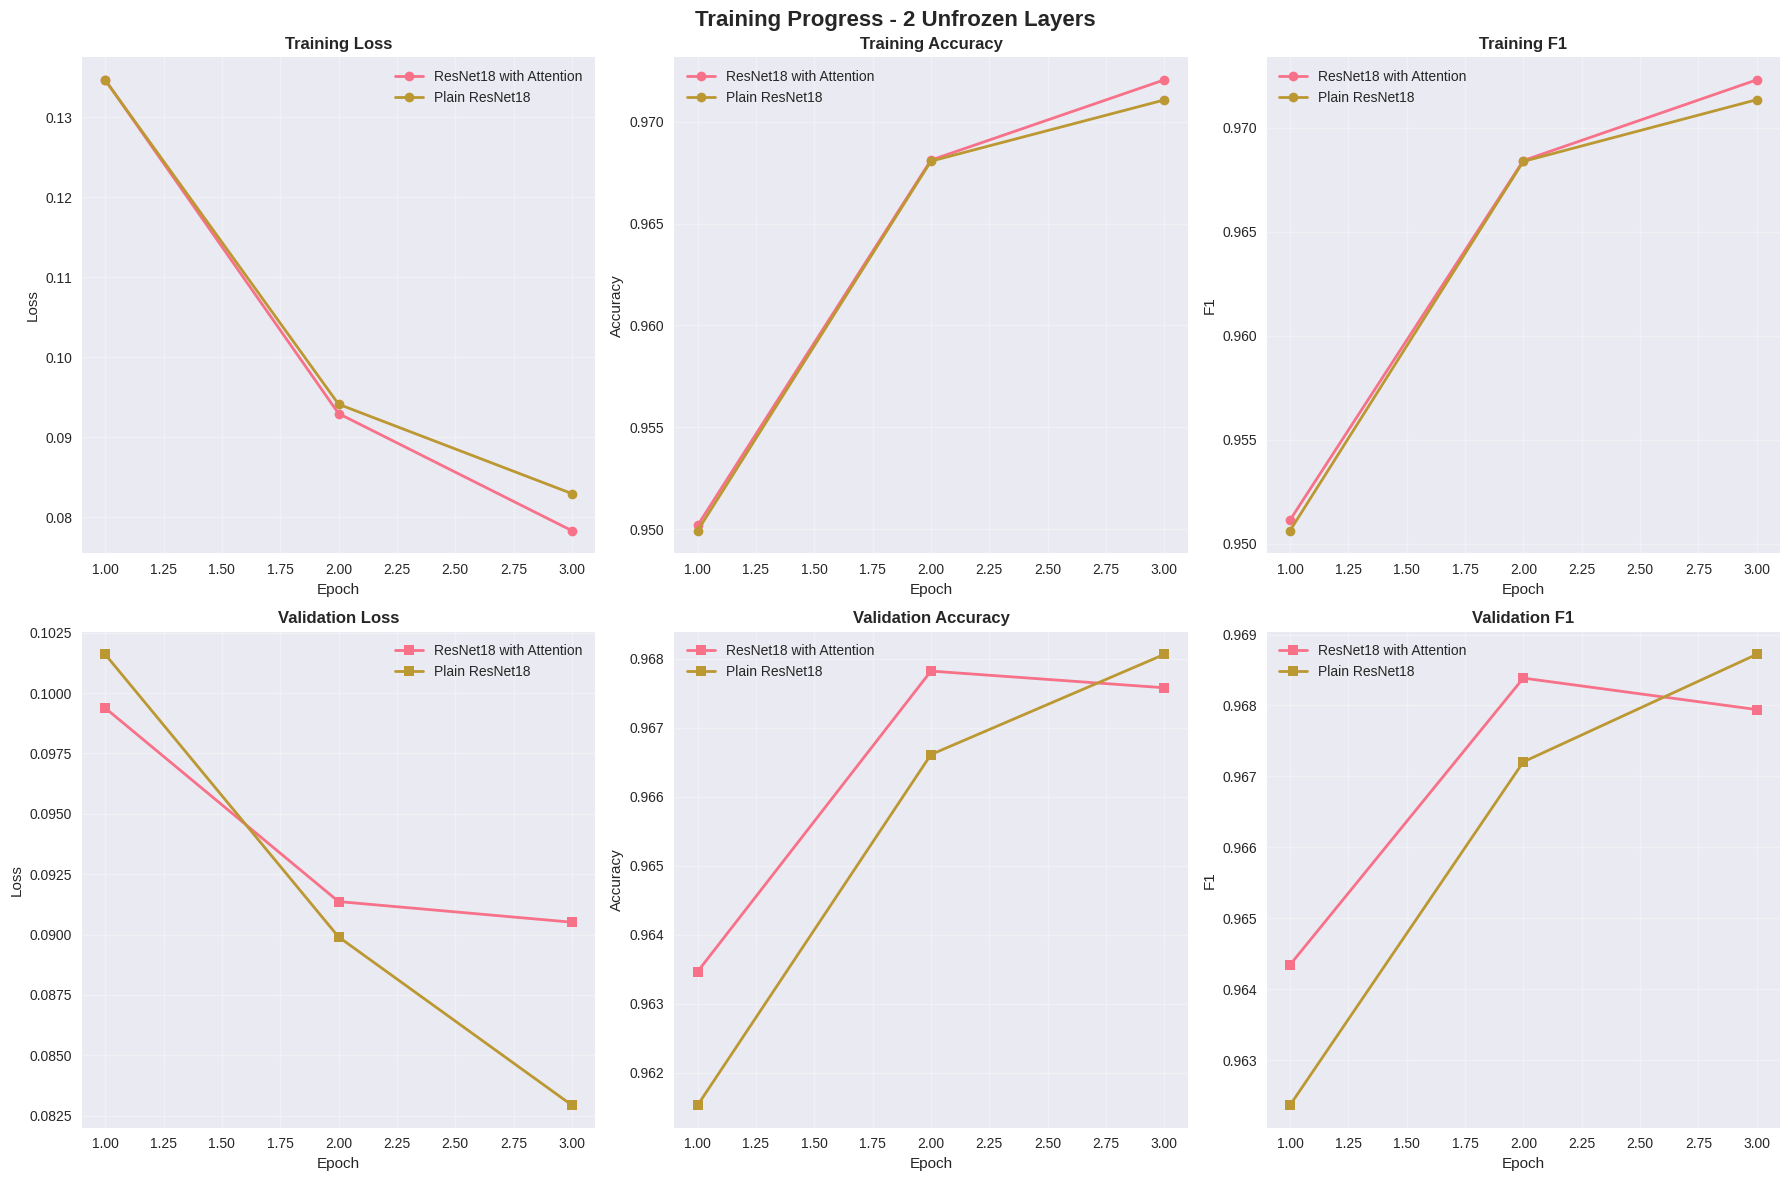

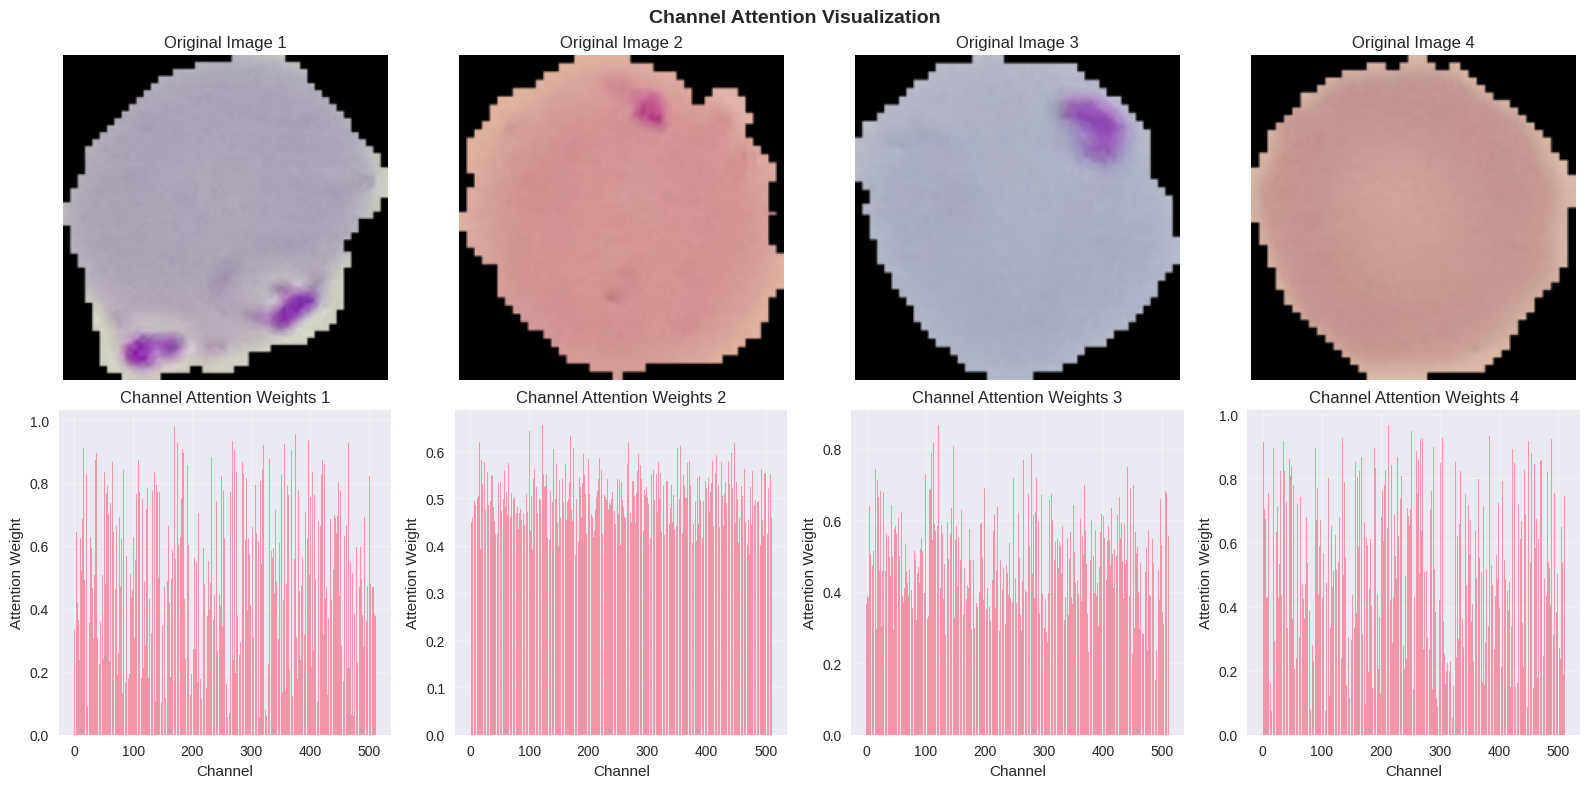

In [17]:
results = analyse(train_loader, val_loader, test_loader, unfreeze_layers=2, epochs=3)
all_results['2'] = results

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of unfrozen layers: 3
Training ResNet18 with Attention model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1241, Acc: 0.9572, F1: 0.9578 | Val Loss: 0.1016, Acc: 0.9656, F1: 0.9656


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0906, Acc: 0.9681, F1: 0.9685 | Val Loss: 0.0922, Acc: 0.9671, F1: 0.9667


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0770, Acc: 0.9728, F1: 0.9730 | Val Loss: 0.0960, Acc: 0.9639, F1: 0.9641


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.0934, Acc: 0.9674, F1: 0.9679


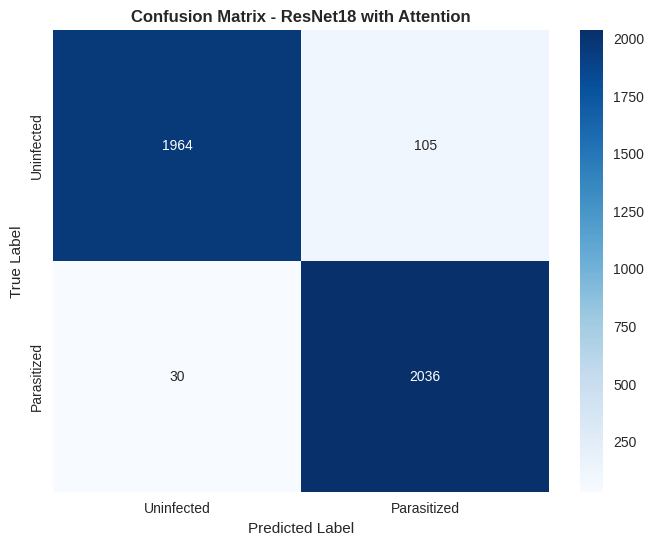

Training Plain ResNet18 model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1268, Acc: 0.9528, F1: 0.9533 | Val Loss: 0.1066, Acc: 0.9671, F1: 0.9671


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0947, Acc: 0.9671, F1: 0.9675 | Val Loss: 0.1045, Acc: 0.9644, F1: 0.9643


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0775, Acc: 0.9721, F1: 0.9724 | Val Loss: 0.0910, Acc: 0.9688, F1: 0.9689


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.0889, Acc: 0.9666, F1: 0.9672


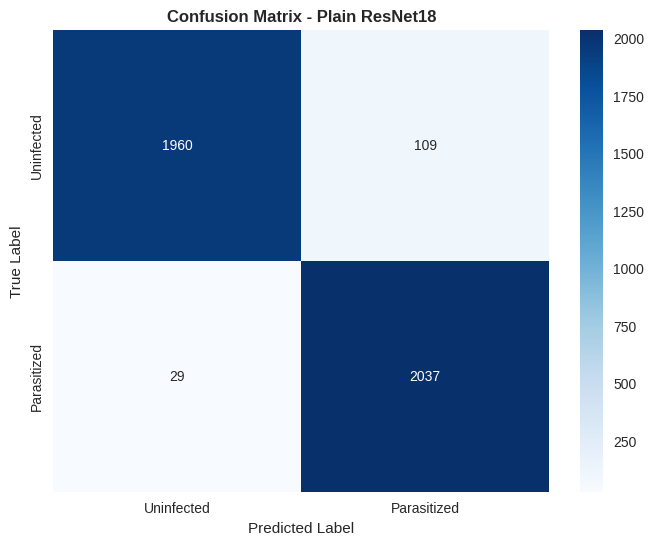

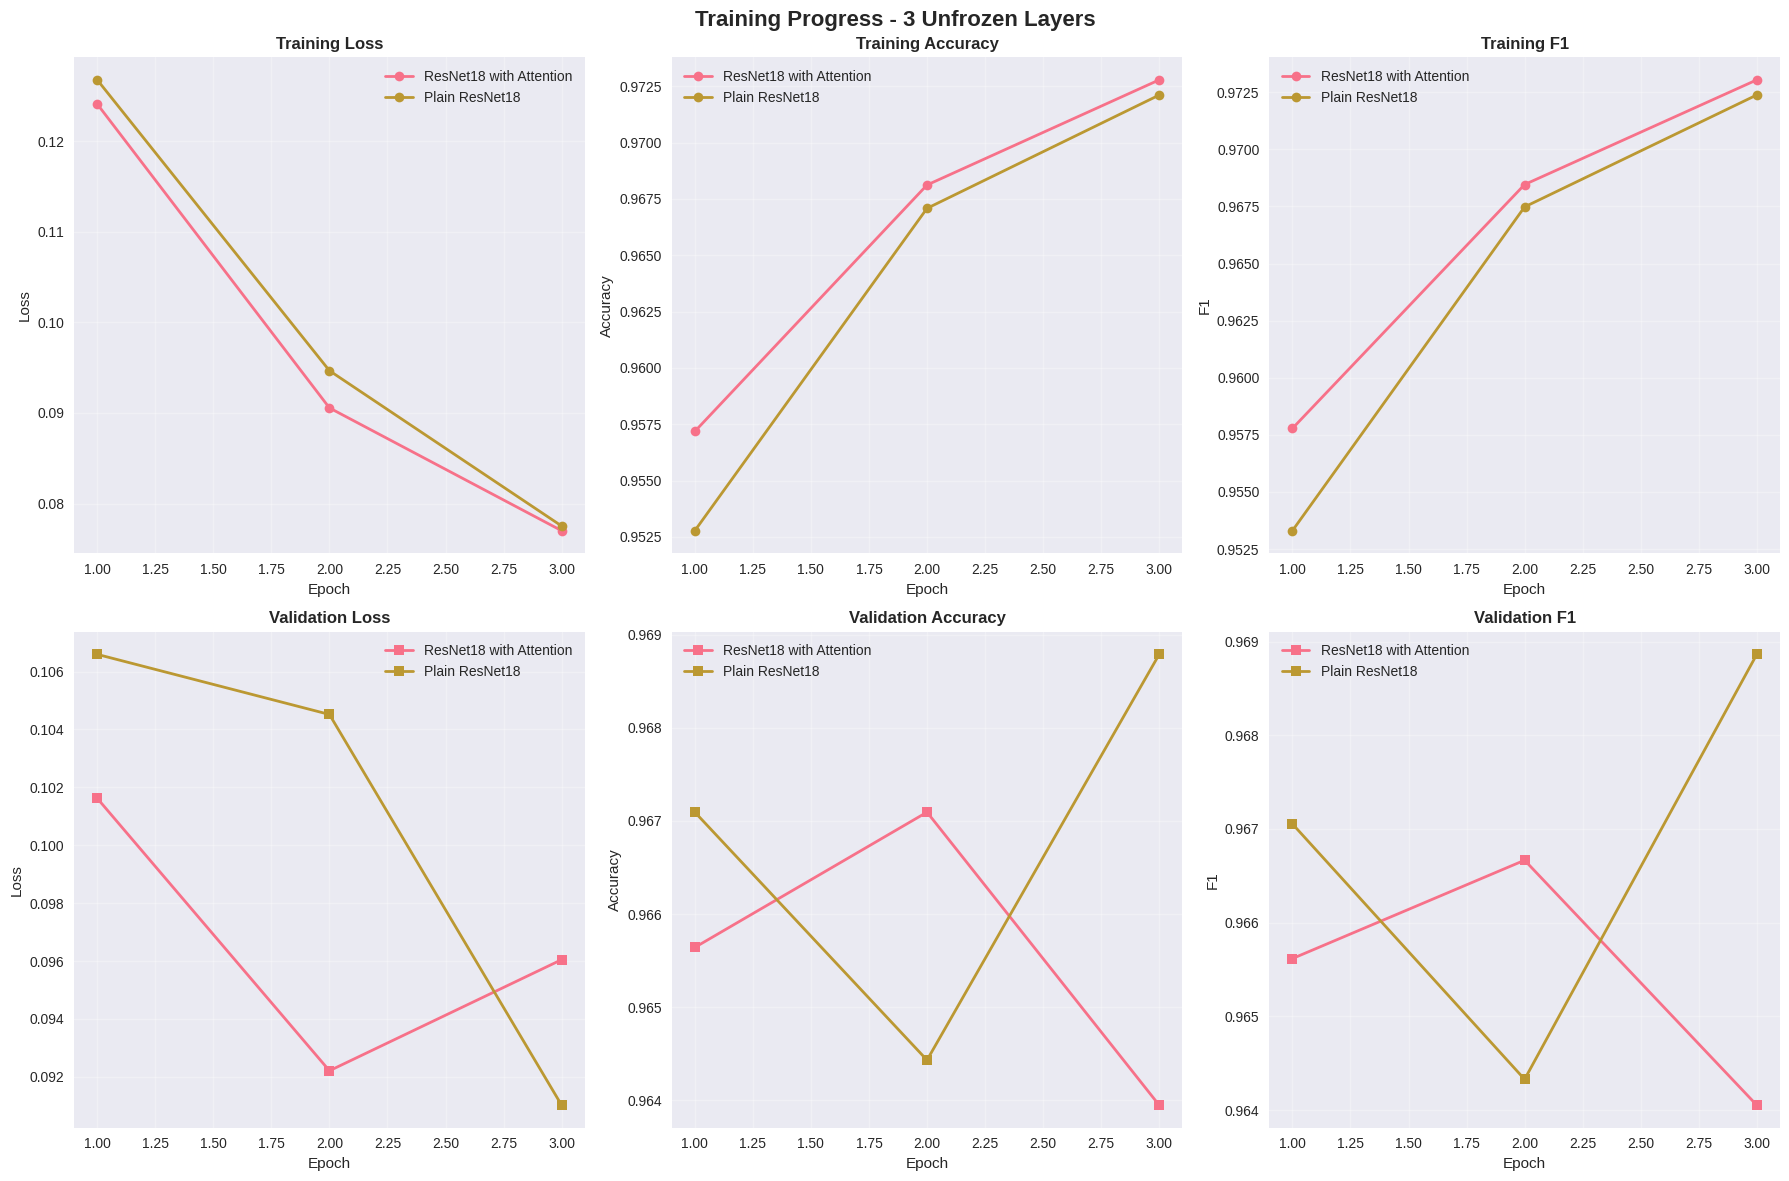

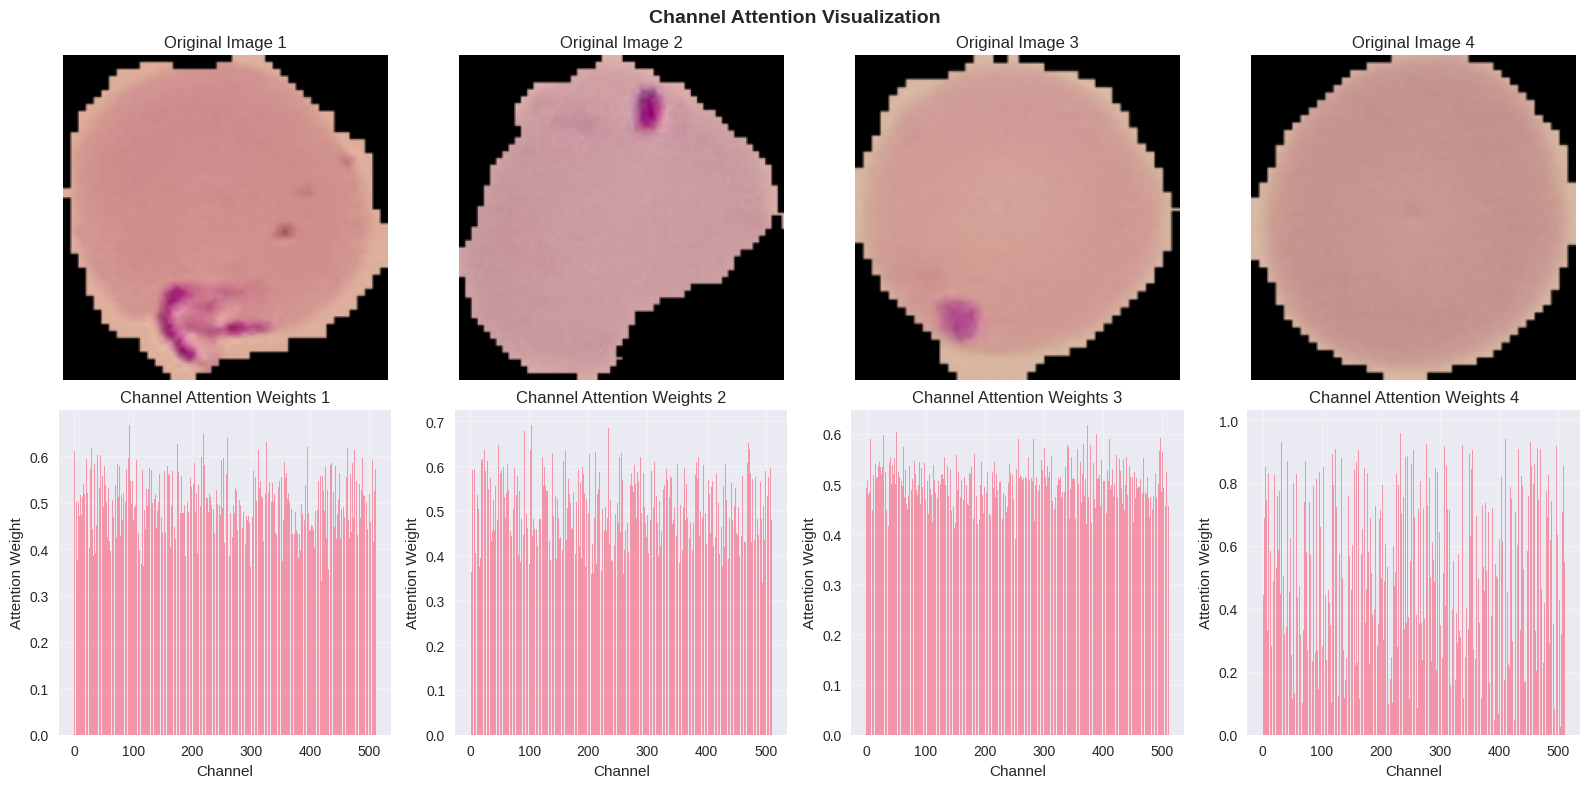

In [17]:
results = analyse(train_loader, val_loader, test_loader, unfreeze_layers=3, epochs=3)
all_results['3'] = results

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of unfrozen layers: 4
Training ResNet18 with Attention model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1271, Acc: 0.9545, F1: 0.9549 | Val Loss: 0.0976, Acc: 0.9669, F1: 0.9682


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0910, Acc: 0.9670, F1: 0.9670 | Val Loss: 0.0910, Acc: 0.9690, F1: 0.9702


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0790, Acc: 0.9722, F1: 0.9722 | Val Loss: 0.0878, Acc: 0.9685, F1: 0.9696


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.0902, Acc: 0.9664, F1: 0.9667


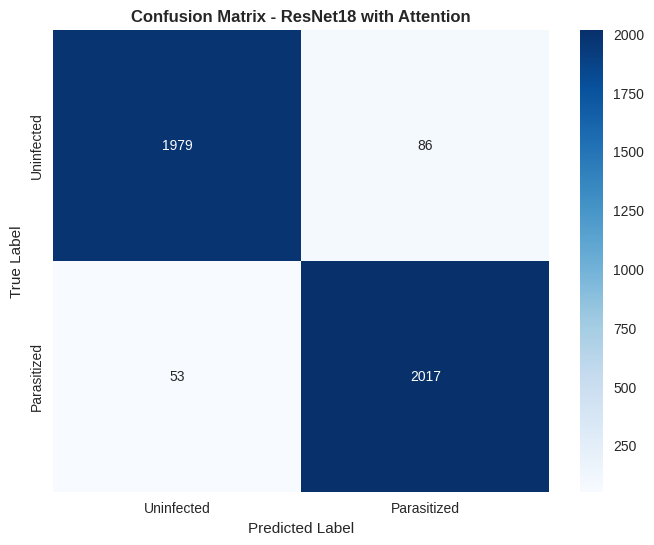

Training Plain ResNet18 model...


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.1257, Acc: 0.9537, F1: 0.9539 | Val Loss: 0.1028, Acc: 0.9644, F1: 0.9662


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0937, Acc: 0.9672, F1: 0.9673 | Val Loss: 0.0964, Acc: 0.9659, F1: 0.9674


Training:   0%|          | 0/302 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0802, Acc: 0.9722, F1: 0.9722 | Val Loss: 0.0970, Acc: 0.9683, F1: 0.9695


Testing:   0%|          | 0/65 [00:00<?, ?it/s]

Final Test Loss: 0.0891, Acc: 0.9681, F1: 0.9685


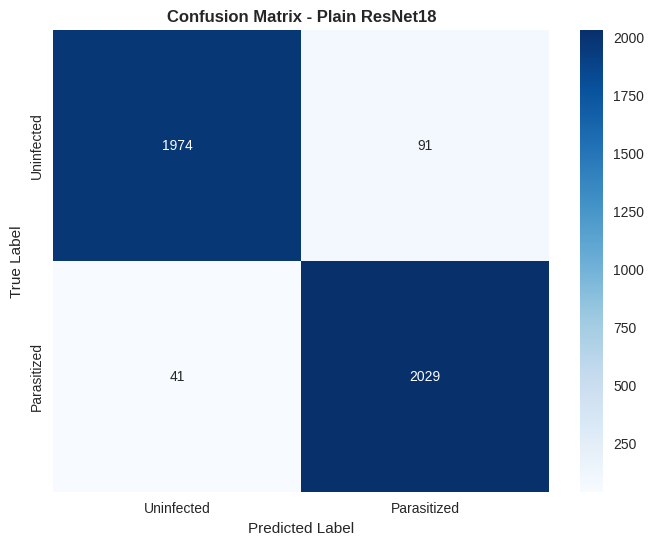

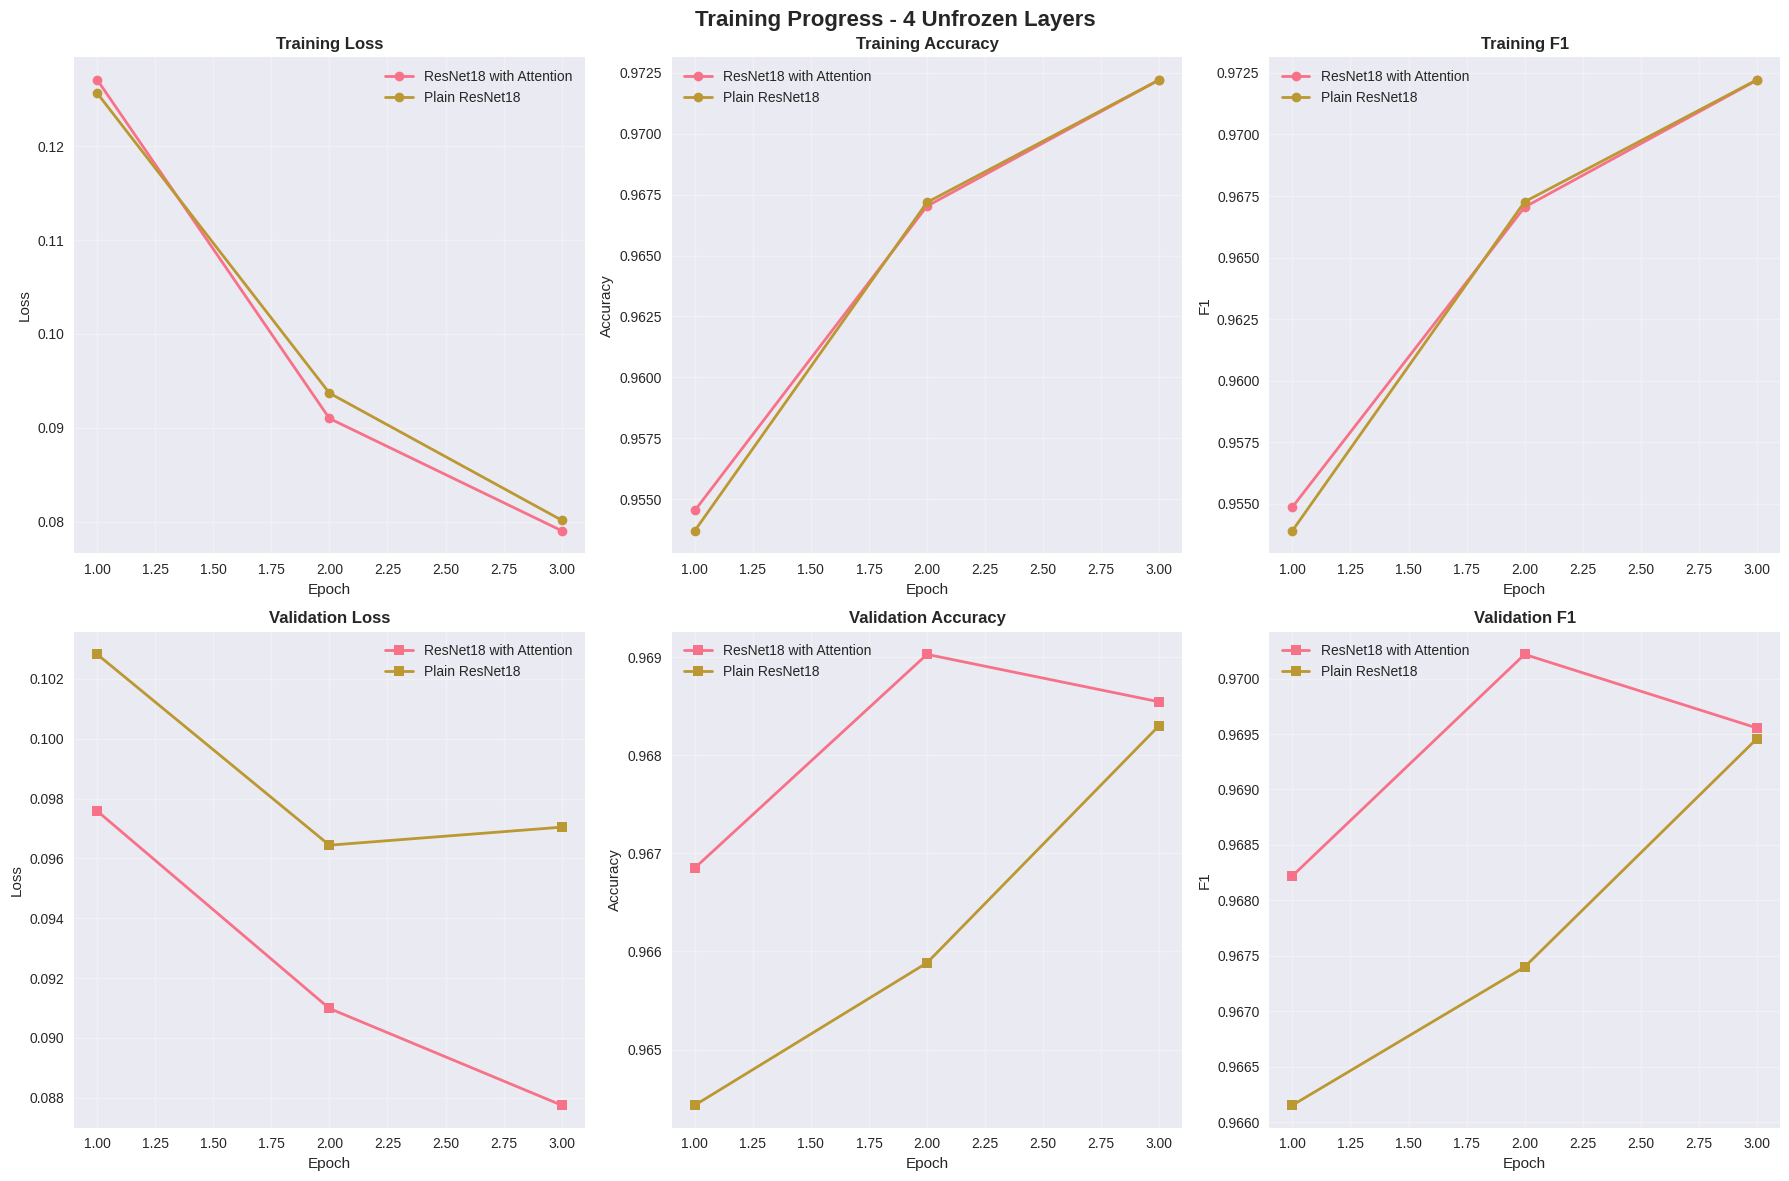

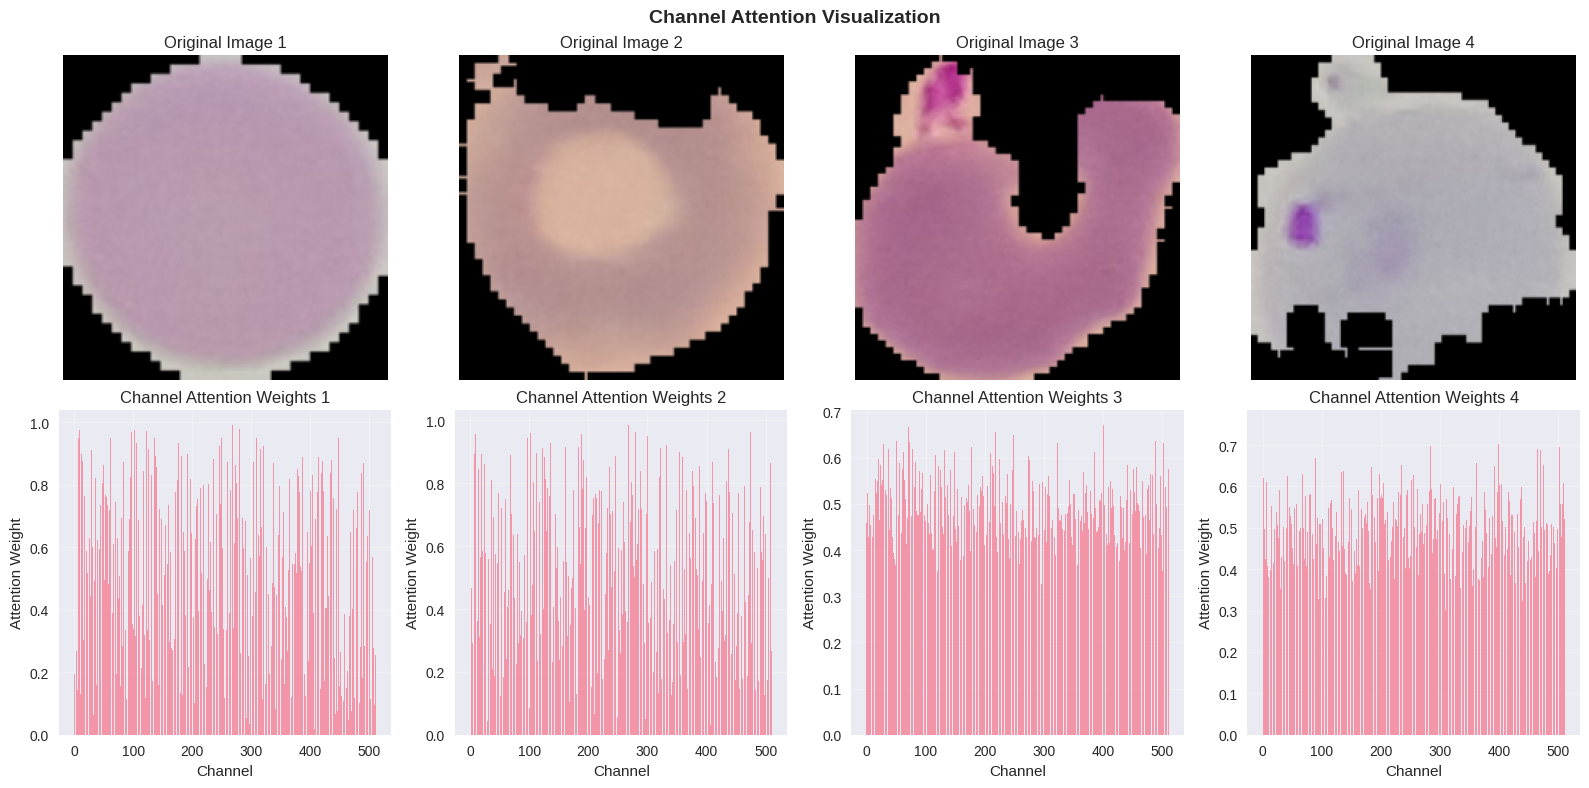

In [16]:
results = analyse(train_loader, val_loader, test_loader, unfreeze_layers=4, epochs=3)
all_results['4'] = results

In [49]:
def plot_model_comparison(all_results):

    """Plot comparison across different unfreezing strategies (Accuracy, F1, and Improvement)"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Comparison Across Unfreezing Strategies', fontsize=18, fontweight='bold')

    # Flatten axes for easier indexing
    axes = axes.flatten()

    unfrozen_layers = sorted([int(k) for k in all_results.keys()])
    metrics = ['test_accuracy', 'test_f1']

    colors = ["#009688", "#FFC107"]

    # Accuracy and F1 plots
    for i, metric in enumerate(metrics):
        ax = axes[i]
        attention_scores = [all_results[str(l)]['ResNet18 with Attention'][metric] * 100 for l in unfrozen_layers]
        plain_scores = [all_results[str(l)]['Plain ResNet18'][metric] * 100 for l in unfrozen_layers]

        x = np.arange(len(unfrozen_layers))
        width = 0.35

        bars1 = ax.bar(x - width/2, attention_scores, width, label='ResNet18 with Attention', color=colors[0])
        bars2 = ax.bar(x + width/2, plain_scores, width, label='Plain ResNet18', color=colors[1])

        ax.set_xlabel('Number of Unfrozen Layers', fontsize=12)
        ax.set_ylabel(f'{metric.replace("test_", "").upper()} (%)', fontsize=12)
        ax.set_title(f'Test {metric.replace("test_", "").upper()}', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(unfrozen_layers, fontsize=11)

        # Zoom y-axis to highlight differences
        ax.set_ylim(85, 100)
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        # Add labels above bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight="bold")

        ax.legend(fontsize=11, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

    # Improvement plot
    ax = axes[2]
    improvements = [ (all_results[str(l)]['ResNet18 with Attention']['test_accuracy'] -
                      all_results[str(l)]['Plain ResNet18']['test_accuracy']) * 100
                     for l in unfrozen_layers]

    bars = ax.bar(unfrozen_layers, improvements, color="#4CAF50", alpha=0.8)
    ax.set_xlabel('Number of Unfrozen Layers', fontsize=12)
    ax.set_ylabel('Accuracy Improvement (%)', fontsize=12)
    ax.set_title('Attention Mechanism Improvement', fontsize=14, fontweight='bold')
    ax.set_xticks(unfrozen_layers)
    ax.set_xticklabels(unfrozen_layers, fontsize=11)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.7)

    # Add labels for improvement
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.1 if imp > 0 else -0.1),
                f'{imp:.2f}%', ha='center', va='bottom' if imp > 0 else 'top',
                fontsize=10, fontweight="bold")

    # Remove the unused 4th subplot
    fig.delaxes(axes[3])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()

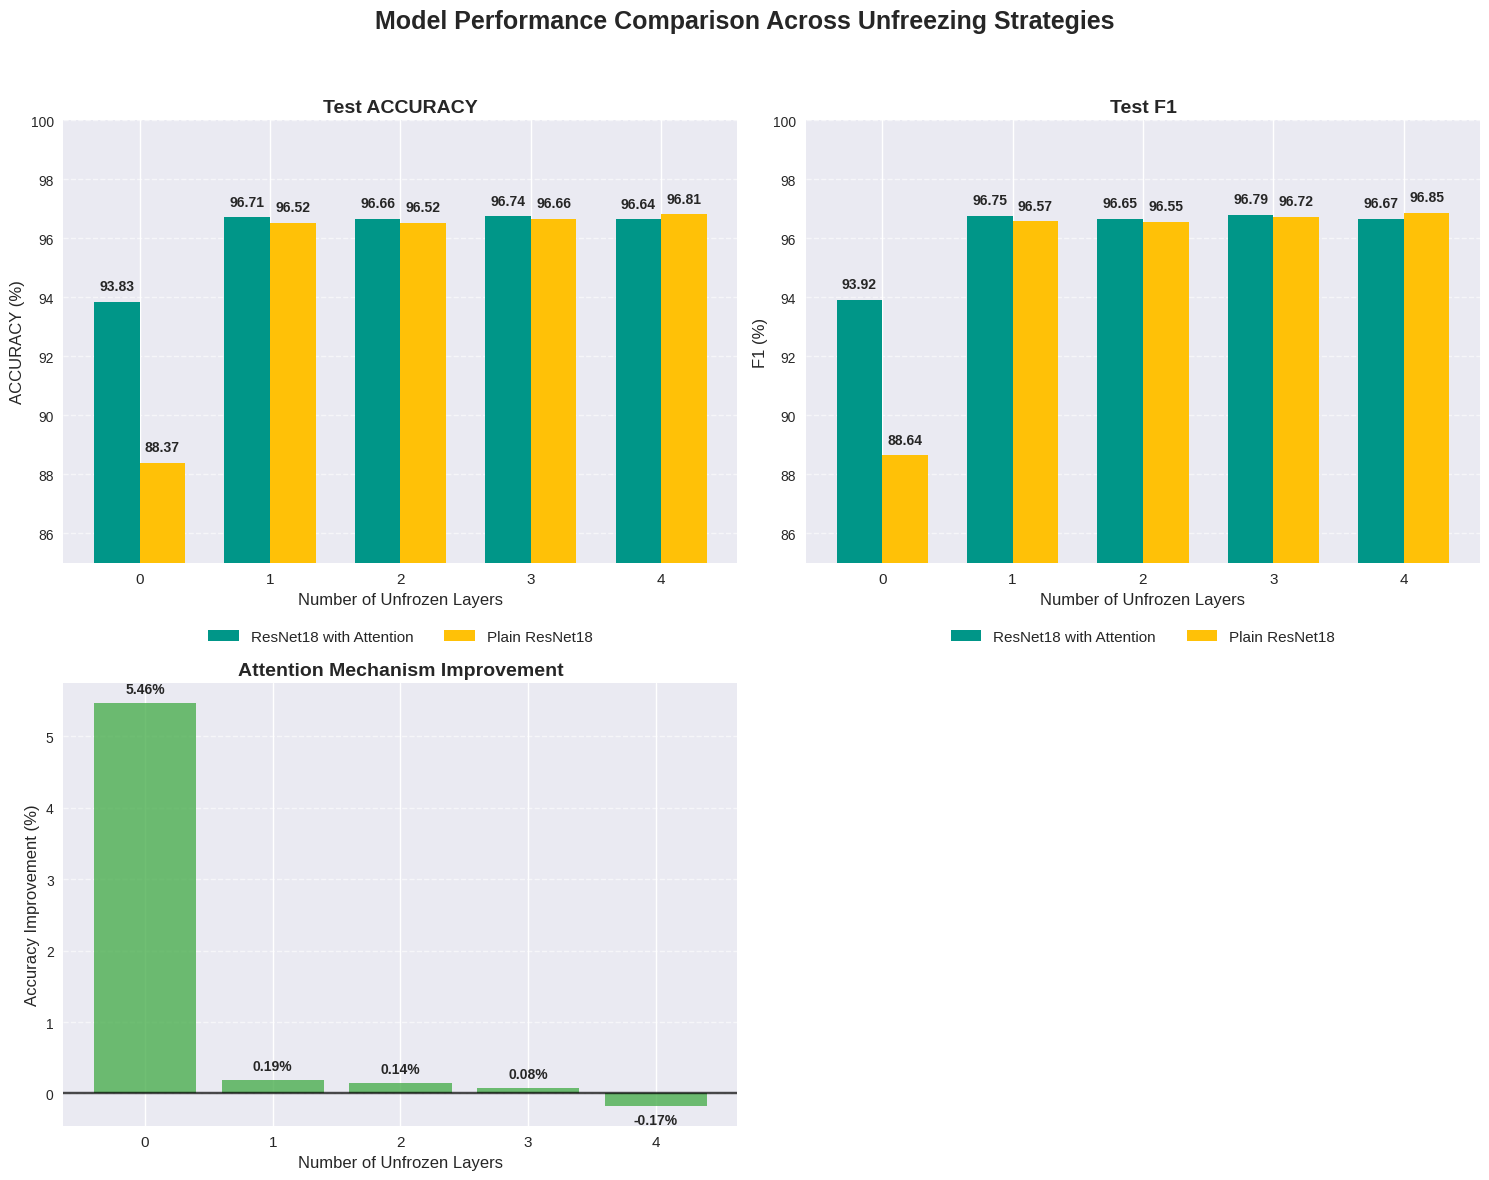

In [50]:
plot_model_comparison(all_results)

In [27]:
# Find best performing configurations
best_attention = max(all_results.items(),
                    key=lambda x: x[1]['ResNet18 with Attention']['test_accuracy'])
best_plain = max(all_results.items(),
                key=lambda x: x[1]['Plain ResNet18']['test_accuracy'])

print(f"\nBest ResNet18 with Attention: {best_attention[1]['ResNet18 with Attention']['test_accuracy']:.4f} "
      f"accuracy with {best_attention[0]} unfrozen layers")
print(f"Best Plain ResNet18: {best_plain[1]['Plain ResNet18']['test_accuracy']:.4f} "
      f"accuracy with {best_plain[0]} unfrozen layers")


Best ResNet18 with Attention: 0.9674 accuracy with 3 unfrozen layers
Best Plain ResNet18: 0.9681 accuracy with 4 unfrozen layers
